In [ ]:
# $ (base) C:\Users\Rubens\Documents>aws configure add-model --service-model file://forecastquery-2018-06-26.normal.json --service-name forecastquery

# $ (base) C:\Users\Rubens\Documents>aws configure add-model --service-model file://forecast-2018-06-26.normal.json --service-name forecast

In [20]:
import boto3
from time import sleep
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
#! pip install awscli --upgrade
#! pip install boto3 --upgrade
#! pip install six==1.11.0
#! pip install botocore==1.12.92
#! pip install s3transfer==0.2.0

In [22]:
session = boto3.Session(region_name='us-east-1') #us-east-1 is also supported

forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')

forecast.list_recipes()

{'RecipeNames': ['forecast_ARIMA',
  'forecast_DEEP_AR',
  'forecast_DEEP_AR_PLUS',
  'forecast_ETS',
  'forecast_MDN',
  'forecast_MQRNN',
  'forecast_NPTS',
  'forecast_PROPHET',
  'forecast_SQF'],
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '174',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 12 Feb 2019 12:59:06 GMT',
   'x-amzn-requestid': '8b234bc5-68fb-43c1-8d7f-516a9d65f1ea'},
  'HTTPStatusCode': 200,
  'RequestId': '8b234bc5-68fb-43c1-8d7f-516a9d65f1ea',
  'RetryAttempts': 0}}

In [25]:
import pandas as pd
trf = pd.read_csv("bike.csv", dtype = object)
trf['itemname'] = 'bike_12'
trf.head(3)

,timestamp,season,holiday,workingday,weather,temp2,atemp2,humidity,windspeed,casual,registered,demand,item_id,itemname
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16.0,bike_12,bike_12
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40.0,bike_12,bike_12
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32.0,bike_12,bike_12


In [26]:
s3 = session.client('s3')
accountId = boto3.client('sts').get_caller_identity().get('Account')

In [27]:
# $ (base) C:\Users\Rubens\Anaconda3>python setup_forecast_permissions.py bucket-vecto-2

In [28]:
roleArn = 'arn:aws:iam::%s:role/amazonforecast'%accountId
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

In [29]:
project = 'bike_forecastdemo'
datasetName= project+'_ds'
datasetGroupName= project +'_gp'
s3DataPath = "s3://"+"bucket-vecto-2"+"/"+key
s3DataPath

's3://bucket-vecto-2/bike.csv'

In [35]:
schema ={
   "Attributes":[    
      { "AttributeName":"timestamp",     "AttributeType":"timestamp"    },      
      { "AttributeName":"season",        "AttributeType":"integer"      },      
      { "AttributeName":"holiday",       "AttributeType":"integer"      },      
      { "AttributeName":"workday",       "AttributeType":"integer"      },      
      { "AttributeName":"weather",       "AttributeType":"integer"      },     
      { "AttributeName":"temperature",   "AttributeType":"float"        },       
      { "AttributeName":"atemp",         "AttributeType":"float"        }, 
      { "AttributeName":"humidity",      "AttributeType":"integer"      },       
      { "AttributeName":"windspeed",     "AttributeType":"float"      },       
      { "AttributeName":"casual",        "AttributeType":"integer"      },      
      { "AttributeName":"registered",    "AttributeType":"integer"      },         
      { "AttributeName":"demand",         "AttributeType":"float"       },      
      { "AttributeName":"item_id",       "AttributeType":"string"       }       
  ]
}

#response=forecast.create_dataset(
#                    Domain="RETAIL",
#                    DatasetType='TARGET_TIME_SERIES',
#                    DataFormat='CSV',
#                    DatasetName=datasetName,
#                    DataFrequency=DATASET_FREQUENCY, 
#                    TimeStampFormat=TIMESTAMP_FORMAT,
#                    Schema = schema
#                   )

In [31]:
predictorName= project+'_mqrnn'
forecastHorizon = 24

In [32]:
createPredictorResponse=forecast.create_predictor(RecipeName='forecast_MQRNN',DatasetGroupName= datasetGroupName ,PredictorName=predictorName, 
  ForecastHorizon = forecastHorizon)

In [33]:
predictorVerionId=createPredictorResponse['VersionId']

In [34]:
while True:
    predictorStatus = forecast.describe_predictor(PredictorName=predictorName,VersionId=predictorVerionId)['Status']
    print(predictorStatus)
    if predictorStatus != 'ACTIVE' and predictorStatus != 'FAILED':
        sleep(30)
    else:
        break

CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
ACTIVE


In [36]:
forecastquery.get_accuracy_metrics(PredictorName=predictorName)
forecast.deploy_predictor(PredictorName=predictorName)
deployedPredictorsResponse=forecast.list_deployed_predictors()
print(deployedPredictorsResponse)

{'PredictorNames': ['bike_forecastdemo_mqrnn'], 'ResponseMetadata': {'RequestId': 'b809c821-383a-4b9d-907d-16f3ae71a4ff', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 12 Feb 2019 13:34:46 GMT', 'x-amzn-requestid': 'b809c821-383a-4b9d-907d-16f3ae71a4ff', 'content-length': '46', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [37]:
while True:
    deployedPredictorStatus = forecast.describe_deployed_predictor(PredictorName=predictorName)['Status']
    print(deployedPredictorStatus)
    if deployedPredictorStatus != 'ACTIVE' and deployedPredictorStatus != 'FAILED':
        sleep(30)
    else:
        break
print(deployedPredictorStatus)

CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
ACTIVE
ACTIVE


In [38]:

forecastResponse = forecastquery.get_forecast(
    PredictorName=predictorName,
    Interval="hour",
   Filters={"item_id":"bike_12"}
)
print(forecastResponse)

{'Forecast': {'ForecastId': '1549979487_8d59499a', 'Predictions': {'mean': [{'Date': '2012-12-20T00:00:00', 'Val': 132.30230712890625}, {'Date': '2012-12-20T01:00:00'}, {'Date': '2012-12-20T02:00:00'}, {'Date': '2012-12-20T03:00:00'}, {'Date': '2012-12-20T04:00:00'}, {'Date': '2012-12-20T05:00:00'}, {'Date': '2012-12-20T06:00:00'}, {'Date': '2012-12-20T07:00:00'}, {'Date': '2012-12-20T08:00:00'}, {'Date': '2012-12-20T09:00:00'}, {'Date': '2012-12-20T10:00:00'}, {'Date': '2012-12-20T11:00:00'}, {'Date': '2012-12-20T12:00:00'}, {'Date': '2012-12-20T13:00:00'}, {'Date': '2012-12-20T14:00:00'}, {'Date': '2012-12-20T15:00:00'}, {'Date': '2012-12-20T16:00:00'}, {'Date': '2012-12-20T17:00:00'}, {'Date': '2012-12-20T18:00:00'}, {'Date': '2012-12-20T19:00:00'}, {'Date': '2012-12-20T20:00:00'}, {'Date': '2012-12-20T21:00:00'}, {'Date': '2012-12-20T22:00:00'}, {'Date': '2012-12-20T23:00:00'}, {'Date': '2012-12-21T00:00:00', 'Val': 1207.568115234375}, {'Date': '2012-12-21T01:00:00'}, {'Date': '201

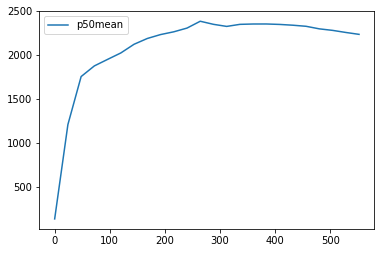

In [43]:
d = pd.DataFrame.from_dict(forecastResponse['Forecast'])
df = pd.DataFrame.from_dict(d.loc['mean']['Predictions']).dropna().rename(columns = {'Val':'p50mean'})
df.plot()

In [44]:
forecastInfoList= forecast.list_forecasts(PredictorName=predictorName)['ForecastInfoList']
forecastId= forecastInfoList[0]['ForecastId']

In [45]:
outputPath="s3://"+"bucket-veccto-2"+"/output"

In [46]:
forecastExportResponse = forecast.create_forecast_export_job(ForecastId=forecastId, OutputPath={"S3Uri": outputPath,"RoleArn":roleArn})

In [47]:
forecastExportJobId = forecastExportResponse['ForecastExportJobId']

In [48]:
while True:
    forecastExportStatus = forecast.describe_forecast_export_job(ForecastExportJobId=forecastExportJobId)['Status']
    print(forecastExportStatus)
    if forecastExportStatus != 'ACTIVE' and forecastExportStatus != 'FAILED':
        sleep(30)
    else:
        break

CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING
CREATING


KeyboardInterrupt: 

In [1]:
#s3.list_objects(Bucket="bucket-vecto-2",Prefix="output")